# ディープラーニング

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation

## TensorFlow

### Low-Level API

インポートしたTensorFlowを使って $y = x^2 + 2$ を定義

In [2]:
x = tf.placeholder(tf.float32, name="x")
c = tf.constant(2.0, name="2")
y = x**c + c

print(x)
print(c)
print(y)

Tensor("x:0", dtype=float32)
Tensor("2:0", shape=(), dtype=float32)
Tensor("add:0", dtype=float32)


In [3]:
sess = tf.Session()
sess.run(y, feed_dict={ x: 3 })

11.0

In [4]:
sess.run((x,y), feed_dict={ x: 3 })

(array(3., dtype=float32), 11.0)

In [5]:
sess.run({'input': x, 'output': y}, feed_dict={ x: 3 })

{'input': array(3., dtype=float32), 'output': 11.0}

In [6]:
sess.run(y, feed_dict={ x: np.arange(20) })

array([  2.,   3.,   6.,  11.,  18.,  27.,  38.,  51.,  66.,  83., 102.,
       123., 146., 171., 198., 227., 258., 291., 326., 363.],
      dtype=float32)

In [7]:
writer = tf.summary.FileWriter('tb_sample')
writer.add_graph(tf.get_default_graph())
writer.flush()

## TensorFlowを用いた予測(Regression)モデルの実装


In [8]:
tab = pd.read_csv("baseball_salary.csv")

In [9]:
# 先頭の5行を表示
tab.head(5)

,球団,推定年俸,守備,年数,年齢,身長,体重,血液型,投打,年,...,併殺打,出塁率,長打率,OPS,RC27,XR27,球団勝率,プレーオフ,球団平均得点,球団打率
0,c,21000,外野手,11,29,177,90,AB型,右左,2017,...,6,0.398,0.505,0.903,7.70,7.52,0.633,2,5.15,0.273
1,c,19000,内野手,7,28,171,72,A型,右右,2017,...,9,0.311,0.405,0.716,4.10,4.01,0.633,2,5.15,0.273
2,c,14000,内野手,5,29,171,85,A型,右左,2017,...,5,0.398,0.407,0.805,6.41,6.26,0.633,2,5.15,0.273
3,c,11500,内野手,7,38,196,126,不明,右右,2017,...,8,0.368,0.532,0.900,6.80,6.90,0.633,2,5.15,0.273
4,c,11000,内野手,20,41,189,102,B型,右右,2017,...,7,0.389,0.461,0.850,6.55,6.54,0.633,2,5.15,0.273


In [10]:
# すべての列名を確認
tab.columns

Index(['球団', '推定年俸', '守備', '年数', '年齢', '身長', '体重', '血液型', '投打', '年', '打率',
       '試合', '打席数', '打数', '安打', '本塁打', '打点', '盗塁', '四球', '死球', '三振', '犠打',
       '併殺打', '出塁率', '長打率', 'OPS', 'RC27', 'XR27', '球団勝率', 'プレーオフ', '球団平均得点',
       '球団打率'],
      dtype='object')

In [11]:
# 利用する特徴量を選択する
input_columns = ['年数','身長','体重','打率','試合',
                '打席数','打数','安打','本塁打','打点',
                '盗塁','四球','死球','三振','犠打','併殺打',
               '出塁率','長打率']
salary_column = ['推定年俸']

data_columns = salary_column + input_columns

In [12]:
def get_scalers(table, colname):
    """tableのカラムcolnameに対して、min–max scalingを行う関数、元に戻す関数を返す"""
    values = table[colname].values
    vmin   = values.min()
    vmax   = values.max()
    scale  = vmax - vmin
    def _scale(tab):
        return (tab[colname].values - vmin)/scale
    def _descale(values):
        return values*scale + vmin
    return dict(scale=_scale, descale=_descale)

In [13]:
# 特徴量ごとのmin–max scalerの辞書を作成
scalers = dict((name, get_scalers(tab, name)) for name in data_columns)

In [14]:
# 正規化された特徴量ベクトルのデータセット
data = np.stack([scalers[name]['scale'](tab) for name in data_columns], axis=1)

In [15]:
# データセットを分割
data_train, data_test = train_test_split(data, test_size=0.2)
data_train, data_validation = train_test_split(data_train, test_size=0.2)

In [16]:
# 分割したデータのshapeを確認しておく
len(data_columns), data_train.shape, data_validation.shape, data_test.shape

(19, (153, 19), (39, 19), (49, 19))

### 年俸予測モデルを実装する

In [17]:
# 隠れ層のニューロン数などのパラメータを定義
n_features = len(input_columns)
n_hidden   = 4
bias_init = 0.1

n_iter = 30000

In [18]:
def inference(features):
    """入力データfeaturesに対して出力データを生成するモデルを定義し、
    出力データに対応するノードを返す"""
    
    # 隠れ層の定義
    with tf.name_scope('hidden'):
        # 重みの定義と初期化指示
        weight1 = tf.Variable(tf.truncated_normal([n_features, n_hidden], stddev=0.1), name="weight1")
        bias1   = tf.Variable(tf.constant(bias_init, shape=[n_hidden]), name="bias1")
        
        # 出力の活性化関数
        output1    = tf.nn.relu(tf.matmul(features, weight1) + bias1) # (n_hidden,)の配列
    
    # 出力層（出力ユニット）の定義
    with tf.name_scope('output'):
        # 重みの定義と初期化指示
        weight2 = tf.Variable(tf.truncated_normal([n_hidden, 1], stddev=0.1), name="weight2")
        bias2   = tf.Variable(tf.constant(bias_init, shape=[1]), name="bias2")
        
        # 出力の活性化関数（output1が参照できていることに注意）
        output2    = tf.nn.relu(tf.matmul(output1, weight2) + bias2)
        
    return output2

def training(loss, rate=0.01):
    """トレーニングのイテレーション（勾配降下法で誤差を最小にする）の定義"""
    with tf.name_scope('training'):
        iteration = tf.train.GradientDescentOptimizer(rate).minimize(loss)
        return iteration

# エラーを保存する場所を用意
bias     = np.empty(n_iter, dtype=float)
variance = np.empty(n_iter, dtype=float)

with tf.Graph().as_default():
    
    # 教師データ用プレースホルダ
    salary      = tf.placeholder(tf.float32, shape=[None,1], name="salary")
    # 入力データ用プレースホルダ
    features    = tf.placeholder(tf.float32, shape=[None,n_features], name="features")
    
    # 定義したプレースホルダをもとに、モデルを生成
    output    = inference(features)
    with tf.name_scope('loss'):
        lossvalue = tf.losses.mean_squared_error(salary, output)
    iteration = training(lossvalue)
    
    # 変数の初期化方法の設定
    init          = tf.global_variables_initializer()
    
    # プレースホルダに投入するデータの設定
    training_data   = { features:  data_train[:,1:], 
                          salary:  data_train[:,:1] }
    validation_data = { features:  data_validation[:,1:],
                          salary:  data_validation[:,:1] }
    test_data       = { features:  data_test[:,1:],
                          salary:  data_test[:,:1] }
    
    # グラフを保存
    writer = tf.summary.FileWriter('summary')
    writer.add_graph(tf.get_default_graph())
    writer.flush()
    
    # セッションを開始して、訓練をおこなう
    with tf.Session() as sess:
        # 変数の初期化
        sess.run(init)
        for i in range(n_iter):
            # 訓練
            _, bias[i]  = sess.run((iteration, lossvalue), feed_dict=training_data)
            # バリデーション
            variance[i] = sess.run(lossvalue, feed_dict=validation_data)
            if i % 500 == 499:
                print('.', end=' ' if i % 5000 == 4999 else '', flush=True)
        
        # テストデータの予測
        test_pred, test_error = sess.run((output, lossvalue), feed_dict=test_data)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
.......... .......... .......... .......... .......... .......... 

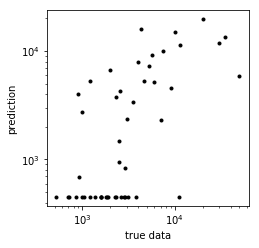

In [20]:
fig = plt.figure(figsize=(4,4))
descaler = scalers['推定年俸']['descale']
plt.plot(descaler(data_test[:,0]), descaler(test_pred), 'k.')
plt.yscale('log')
plt.xscale('log')
plt.xlabel("true data")
plt.ylabel("prediction")
plt.subplots_adjust(bottom=.2, left=.2)
fig.savefig("images/tf_regression_prediction.png")
plt.show()

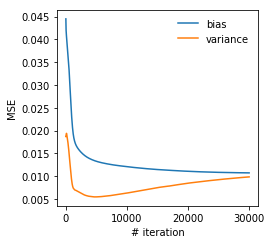

In [21]:
fig = plt.figure(figsize=(4, 4))
plt.plot(bias, label='bias')
plt.plot(variance, label='variance')
plt.legend(frameon=False)
plt.xlabel("# iteration")
plt.ylabel("MSE")
plt.subplots_adjust(bottom=.2, left=.2)
fig.savefig('images/tf_regression_errors.png')
plt.show()

### Early stopping

「今までの最小バリアンスよりも0.01%以上大きくなったら訓練をやめる」というロジックを組み込む

In [22]:
# 最小のバリデーション誤差を保存しておく
min_mse = np.inf
# Early stoppingをかける閾値となるMSEの大きさ
threshold = 1.0001

with tf.Graph().as_default():
    
    # 教師データ用プレースホルダ
    salary      = tf.placeholder(tf.float32, shape=[None,1], name="salary")
    # 入力データ用プレースホルダ
    features    = tf.placeholder(tf.float32, shape=[None,n_features], name="features")
    
    # 定義したプレースホルダをもとに、モデルを生成
    output    = inference(features)
    with tf.name_scope('loss'):
        lossvalue = tf.losses.mean_squared_error(salary, output)
    iteration = training(lossvalue)
    
    # 変数の初期化方法の設定
    init          = tf.global_variables_initializer()
    
    # プレースホルダに投入するデータの設定
    training_data   = { features:  data_train[:,1:], 
                          salary:  data_train[:,:1] }
    validation_data = { features:  data_validation[:,1:],
                          salary:  data_validation[:,:1] }
    test_data       = { features:  data_test[:,1:],
                          salary:  data_test[:,:1] }
    
    # セッションを開始して、訓練をおこなう
    with tf.Session() as sess:
        # 変数の初期化
        sess.run(init)
        for i in range(n_iter):
            # 訓練
            _, _  = sess.run((iteration, lossvalue), feed_dict=training_data)
            # バリデーション
            var = sess.run(lossvalue, feed_dict=validation_data)
            if var < min_mse:
                min_mse = var
            elif var > (min_mse * threshold):
                # バリアンスが大きくなってきた
                print(f"abort({i})")
                total_iterations = i
                break
                
            if i % 500 == 499:
                print('.', end=' ' if i % 5000 == 4999 else '', flush=True)
        
        # テストデータの予測
        test_pred_early, test_error_early = sess.run((output, lossvalue), feed_dict=test_data)

abort(1)


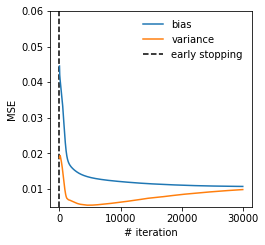

In [23]:
fig = plt.figure(figsize=(4, 4))
plt.plot(bias, label='bias')
plt.plot(variance, label='variance')
plt.vlines(total_iterations, 0.005, 0.06, color='k', linestyles='dashed', linewidth=1.5, label='early stopping')
plt.legend(frameon=False)
plt.xlabel("# iteration")
plt.ylabel("MSE")
plt.ylim(0.005, 0.06)
plt.subplots_adjust(bottom=.2, left=.2)
fig.savefig('images/tf_earlystopping_errors.png')
plt.show()

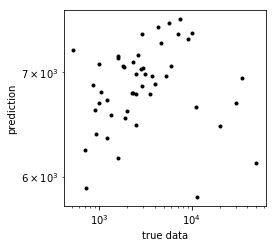

In [24]:
# 散布図を描画する
fig = plt.figure(figsize=(4,4))
descaler = scalers['推定年俸']['descale']
plt.plot(descaler(data_test[:,0]), descaler(test_pred_early), 'k.')
plt.yscale('log')
plt.xscale('log')
plt.xlabel("true data")
plt.ylabel("prediction")
plt.subplots_adjust(bottom=.2, left=.2)
fig.savefig("images/tf_earlystopping_prediction.png")
plt.show()

## Keras

### Keras(High-level API)によるモデル構築


In [25]:
# パラメータの設定
n_features = len(input_columns)
n_hidden   = 4
bias_init  = 0.1

# 学習率
rate       = 0.01

model = keras.Sequential()
# 隠れ層の追加
model.add(Dense(n_hidden, activation='relu', input_shape=(n_features,),
                kernel_initializer=keras.initializers.TruncatedNormal(stddev=0.1),
                bias_initializer=keras.initializers.constant(bias_init)))
# 出力層の追加
model.add(Dense(1, activation='relu', 
                kernel_initializer=keras.initializers.TruncatedNormal(stddev=0.1),
                bias_initializer=keras.initializers.constant(bias_init)))

# 勾配降下法を用いた二乗誤差の最小化スキームを利用して、TensorFlowのモデルを構築
model.compile(optimizer=tf.train.GradientDescentOptimizer(rate),
              loss='mse', metrics=['mae'])

In [26]:
# フィッティング
log = model.fit(data_train[:,1:], data_train[:,:1], epochs=5000, batch_size=64, verbose=False,
         validation_data=(data_validation[:,1:], data_validation[:,:1]))

Instructions for updating:
Use tf.cast instead.


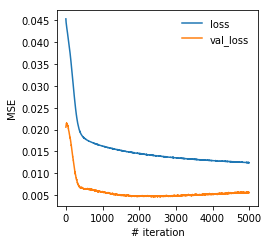

In [27]:
# グラフ表示
fig = plt.figure(figsize=(4,4))
plt.plot(log.history['loss'], label='loss')
plt.plot(log.history['val_loss'], label='val_loss')
plt.xlabel("# iteration")
plt.ylabel("MSE")
plt.legend(frameon=False)
plt.subplots_adjust(bottom=.2, left=.2)
fig.savefig('images/keras_regression_errors.png')
plt.show()

In [28]:
# パラメータの設定
n_features = len(input_columns)
n_hidden   = 4
bias_init  = 0.1

# 学習率
rate       = 0.01

model = keras.Sequential()
# 隠れ層の追加
model.add(Dense(n_hidden, activation='relu', input_shape=(n_features,),
                kernel_initializer=keras.initializers.TruncatedNormal(stddev=0.1),
                bias_initializer=keras.initializers.constant(bias_init)))
# 出力層の追加
model.add(Dense(1, activation='relu', 
                kernel_initializer=keras.initializers.TruncatedNormal(stddev=0.1),
                bias_initializer=keras.initializers.constant(bias_init)))

model.compile(optimizer=tf.train.GradientDescentOptimizer(rate),
              loss='mse', metrics=['mae'])

log = model.fit(data_train[:,1:], data_train[:,:1], epochs=3000, batch_size=64, verbose=False,
                callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                         min_delta=0, patience=100, 
                                                         verbose=1)],
                validation_data=(data_validation[:,1:], data_validation[:,:1]))

Epoch 00101: early stopping


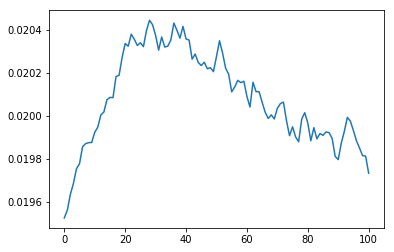

In [29]:
# グラフ表示
plt.plot(log.history['val_loss'], label='val_loss')

In [30]:
pred = model.predict(data_test[:,1:])

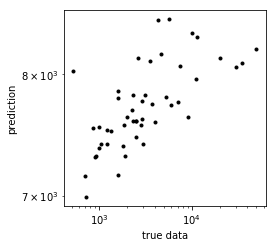

In [31]:
# 散布図の表示
fig = plt.figure(figsize=(4,4))
descaler = scalers['推定年俸']['descale']
plt.plot(descaler(data_test[:,0]), descaler(pred), 'k.')
plt.yscale('log')
plt.xscale('log')
plt.xlabel("true data")
plt.ylabel("prediction")
plt.subplots_adjust(bottom=.2, left=.2)
fig.savefig("images/keras_earlystopping_prediction.png")
plt.show()